<a href="https://colab.research.google.com/github/zia207/Deep-Neural-Network-Satellite-Image-Classification-in-Google-Colaboratory-iPython-Note-Book-/blob/master/NoteBook/Advance_Regression/02-02-04-poisson-regression-overdispersion-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 4. Poisson Regression Models for Overdispersed Data

When analyzing count data, you may encounter overdispersion, which occurs when the observed variability in the data is more significant than what a standard Poisson model would predict. Overdispersion often arises in real-world datasets because natural processes can introduce more variability than a simple Poisson model can accommodate. Ignoring overdispersion can lead to underestimated standard errors, unreliable confidence intervals, and misleading conclusions.

In this tutorial, we will explore methods for modeling overdispersed count data in R, focusing on approaches such as quasi-Poisson and negative binomial models, which can manage the extra variability in the data. We will begin by discussing the implications of overdispersion, then move on to fitting models from scratch and using R’s `glm()` function. After that, we’ll examine model diagnostics to detect overdispersion, evaluate the models to ensure a proper fit, and interpret incidence rate ratios (IRRs).


## Overview

**Poisson regression** is used to model count data where the response variable represents the number of occurrences of an event. A key assumption of the Poisson model is that the **mean** and the **variance** of the response variable are equal:

$$ \text{Var}(Y) = \mu $$

Where $(Y)$ is the count response variable, and $\mu$ is the mean (expected value) of the counts. However, in many real-world datasets, this assumption is often violated. When the variance is **greater than the mean**, the data exhibit **overdispersion**. Overdispersion can lead to underestimated standard errors and, as a result, inflated Type I error rates (i.e., falsely concluding that a predictor is significant).

***Causes of Overdispersion***

Overdispersion in count data can occur for several reasons, including:
1. **Unobserved heterogeneity**: There might be additional variables or factors influencing the count data that are not included in the model.
2. **Zero-inflation**: There might be an excess of zeros in the data compared to what the Poisson model predicts.
3. **Clustering**: Observations within clusters may be more similar than those across clusters, leading to greater variability than assumed.

***Identifying Overdispersion****

-   The variance is much greater than the mean, which suggests that we will have **over-dispersion** in the model.

-   **Deviance**: If the deviance is much larger than the degrees of freedom, it suggests overdispersion. We can estimate a dispersion parameter, $ϕ$ by dividing the model deviance by its corresponding degrees of freedom; i.e.,

$$ ϕ^2 = \frac{\sum Residuals^2}{n-p} $$

- If this statistic is significantly greater than 1, it suggests the presence of overdispersion.


- You can also examine the **Pearson Chi-Square statistic** divided by the degrees of freedom as another indicator of overdispersion.

***Handling Overdispersion in Poisson Regression***

When overdispersion is present, Poisson regression is not appropriate, and alternative models are needed. There are several approaches to address overdispersion:

1. **Quasi-Poisson Regression**: A simple extension where the Poisson model is adjusted to allow for overdispersion by adding a dispersion parameter.
2. **Negative Binomial Regression**: A more flexible model that explicitly accounts for overdispersion by allowing the variance to differ from the mean.
3. **Zero-Inflated Models**: Useful when the overdispersion is caused by excess zeros in the data.



## Install rpy2

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Quasi-Poisson model

**Quasi-Poisson** regression addresses the issue of overdispersion by allowing the variance to be a multiple of the mean, rather than strictly equal to the mean in traditional Poisson regression. This multiple, known as the dispersion parameter, is estimated from the data. By relaxing the assumption of equal mean and variance, quasi-Poisson regression can provide a more flexible model that better fits count data with overdispersion.

The quasi-Poisson model is a generalized linear model used for count data that assumes the variance of the response variable is proportional to its mean. It's particularly useful when dealing with count data that exhibits overdispersion, where the variance is greater than the mean.

Let's denote the response variable as $Y$, the predictor variables as $X_1, X_2, ..., X_p$, and the parameters of the model as $\beta_0, \beta_1, ..., \beta_p$. The model can be represented as:

$$ Y \sim \text{Poisson}(\lambda) $$

where $\lambda$ is the mean parameter of the Poisson distribution, given by:

$$ \lambda = \exp(\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p) $$

In the quasi-Poisson model, the variance of $Y$ is allowed to be a multiple $\phi$ of the mean, so the variance function is given by:

$$ \text{Var}(Y) = \phi \lambda $$

where $\phi$ is the dispersion parameter. When $\phi = 1$, the quasi-Poisson model reduces to a standard Poisson model. When $\phi > 1$, it indicates overdispersion, and when $\phi < 1$, it indicates underdispersion.

The estimation of parameters $\beta_0, \beta_1, ..., \beta_p$ in a quasi-Poisson model is typically done using **maximum likelihood estimation (MLE)**. Maximum Likelihood Estimation (MLE) is a method used for estimating the parameters of a statistical model. It's based on the principle of maximizing the likelihood function, which represents the probability of observing the given data given the parameters of the model.Additionally, the dispersion parameter $\phi$ can also be estimated from the data.

Quasi-Poisson regression is particularly useful for count data where there may be unobserved or unaccounted-for sources of variation leading to greater variability than expected under a strict Poisson distribution. It is commonly used in fields such as epidemiology, ecology, and social sciences where count data is prevalent..

Below is a summary of the comparison between Poisson inference, which assumes no overdispersion, and quasi-Poisson inference, which accounts for overdispersion, in terms of tests and confidence intervals.

![alt text](http://drive.google.com/uc?export=view&id=1Kgt4w6dy9qHclF_X8nzoV1tz3nOKGcSO)


(Source: [Paul Roback and Julie Legler, 2021, Chapter 4 Poisson Regression. Beyond Multiple Linear Regression](https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html#sec-overdispPois))


To fit a Quasi-Poisson model manually without using `glm()` function in R, you can follow will steps below:

* Create a sample dataset with overdispersion
* Fit a  Poisson model
* Estimate overdispersion parameter
* Adjusting Standard Errors, t-test and Confidence Intervals

### Generate a Sample Data

To create overdispersed count data for a Poisson regression model with 4 covariates and an offset, we can start with a basic Poisson model, then introduce extra variability by adding random noise from a Gamma distribution (often used to simulate overdispersion).

In [ ]:
%%R
# set seed
set.seed(42)  # for reproducibility

# Number of observations
n <- 500

# Generate covariates
x1 <- rnorm(n)
x2 <- rnorm(n)
x3 <- rnorm(n)
x4 <- rnorm(n)

# Generate offset variable (positive values, often log-transformed)
offset_var <- log(1 + abs(rnorm(n)))

# Define the true coefficients for each covariate and the intercept
beta <- c(0.5, -0.3, 0.2, 0.1, 0.7)  # intercept and 4 coefficients

# Calculate the linear predictor (eta) and expected Poisson mean
eta <- beta[1] + beta[2] * x1 + beta[3] * x2 + beta[4] * x3 + beta[5] * x4 + offset_var
mu <- exp(eta)  # Poisson mean

# Add overdispersion by using a Gamma distribution to introduce extra variation
# Gamma mean = 1, shape parameter controls the level of overdispersion
# Smaller shape (e.g., < 1) introduces more overdispersion
shape_param <- 0.5
overdispersion_noise <- rgamma(n, shape = shape_param, scale = 1 / shape_param)

# Multiply the Poisson mean by the overdispersion noise to get the final mean
y_overdispersed <- rpois(n, lambda = mu * overdispersion_noise)

# Compile into a data frame
data <- data.frame(y = y_overdispersed, x1 = x1, x2 = x2, x3 = x3, x4 = x4, offset_var = offset_var)

# View the structure and first few rows of the data to check
head(data)

  y         x1           x2         x3         x4 offset_var
1 0  1.3709584  1.029140719  2.3250585 -0.6013830  0.2236059
2 3 -0.5646982  0.914774868  0.5241222 -0.1358161  0.2452369
3 0  0.3631284 -0.002456267  0.9707334 -0.9872728  1.0023714
4 0  0.6328626  0.136009552  0.3769734  0.8319250  1.1008448
5 0  0.4042683 -0.720153545 -0.9959334 -0.7950595  0.8293412
6 0 -0.1061245 -0.198124330 -0.5974829  0.3404646  0.3117683


### Fit a Poisson Model with Offset

Define the Poisson log-likelihood function and maximize it with `optim()`

In [ ]:
%%R
# Log-likelihood function for Poisson regression with offset
poisson_log_likelihood_offset <- function(params) {
  beta0 <- params[1]
  beta1 <- params[2]
  beta2 <- params[3]
  beta3 <- params[4]
  beta4 <- params[5]

  # Compute lambda (expected counts)
  lambda <- exp(beta0 + beta1 * data$x1 + beta2 * data$x2 + beta3 * data$x3 + beta4 * data$x4 + data$offset)

  # Log-likelihood for Poisson with offset
  log_likelihood <- sum(dpois(data$y, lambda, log = TRUE))

  return(-log_likelihood)  # Negative for minimization
}

# Initial guesses for beta coefficients
initial_params <- rep(0, 5)

# Use optim to find MLEs for the coefficients
fit <- optim(par = initial_params, fn = poisson_log_likelihood_offset, hessian = TRUE)

# Extract parameter estimates and standard errors
coefficients <- fit$par
std_errors <- sqrt(diag(solve(fit$hessian)))

# Calculate Z-scores and p-values
z_scores <- coefficients / std_errors
p_values <- 2 * (1 - pnorm(abs(z_scores)))

# Create summary table
summary_table <- data.frame(
  Coefficient = coefficients,
  Std_Error = std_errors,
  Z_value = z_scores,
  P_value = p_values
)

# Assign row names for clarity
row.names(summary_table) <- c("Intercept", "x1", "x2", "x3", "x4")

# Display summary table
print(summary_table)

          Coefficient  Std_Error    Z_value      P_value
Intercept   0.4648224 0.02897226  16.043705 0.000000e+00
x1         -0.3138090 0.02326024 -13.491220 0.000000e+00
x2          0.2589814 0.02190686  11.821935 0.000000e+00
x3          0.1763499 0.02448229   7.203165 5.884182e-13
x4          0.6133713 0.02316479  26.478603 0.000000e+00


### Estimate Overdispersion Parameter

In a Quasi-Poisson model, overdispersion can be accounted for by using the estimated dispersion parameter to adjust model fit statistics, including the standard errors of the coefficient estimates, hypothesis tests, and other inferential measures. Here’s a detailed explanation of how this works:

In [ ]:
%%R
# estimaates
estimates <- fit$par
names(estimates ) <- c("beta0", "beta1", "beta2", "beta3", "beta4")
# Calculate fitted values
lambda_hat <- exp(estimates[1] + estimates[2] * data$x1 + estimates[3] * data$x2 +
                  estimates[4] * data$x3 + estimates[5] * data$x4 + data$offset)


# Calculate Pearson residuals
pearson_residuals <- (data$y - lambda_hat) / sqrt(lambda_hat)

# Calculate dispersion statistic
dispersion_statistic <- sum(pearson_residuals^2) / (n - length(estimates))

# Display dispersion statistic
cat("Dispersion Statistic:", dispersion_statistic, "\n")

# If the dispersion statistic is much greater than 1, overdispersion is present
if (dispersion_statistic > 1.2) {
  cat("Warning: Evidence of overdispersion\n")
} else {
  cat("No evidence of overdispersion\n")
}

Dispersion Statistic: 8.619667 


### Adjusting Standard Errors, t-test and Confidence Intervals

When overdispersion is present, the standard errors calculated in a Poisson model underestimate the variability in the data. In the Quasi-Poisson approach, the standard errors are adjusted by multiplying by the square root of the dispersion parameter, $\phi$ (also called the quasi-likelihood variance or scale parameter).

If the dispersion parameter, $\phi$, is estimated as:

$$ \phi = \frac{\sum (y_i - \hat{y}_i)^2 / \hat{y}_i}{n - p} $$

where: - $y_i$ is the observed response, - $\hat{y}_i$ is the fitted response, - $n$ is the number of observations, and - $p$ is the number of estimated parameters in the model.

Then, the adjusted standard error of each coefficient, $SE_{\text{adjusted}}$, is calculated as:

$$ SE_{\text{adjusted}} = SE_{\text{Poisson}} \times \sqrt{\phi}$$

where $SE_{\text{Poisson}}$ is the standard error from the original Poisson model.

With the adjusted standard errors, hypothesis tests for coefficients (using $t$-tests) and confidence intervals are also adjusted. For each coefficient ( \beta\_j ):

-   **Adjusted** $t$-statistic: The $t$-statistic is calculated as $t_j = \frac{\hat{\beta_j}}{SE_{\text{adjusted}}}$.

-   **Confidence Intervals:** Adjusted confidence intervals are calculated as:

$$  \text{CI}_{j} = \hat{\beta_j} \pm t_{\alpha/2, \, \text{df}} \times SE_{\text{adjusted}} $$

where $t_{\alpha/2, \, \text{df}}$ is the critical $t$-value for the desired confidence level and degrees of freedom.

### Adjusting Model Fit Statistics (e.g., Deviance and Residual Deviance)

For model comparison, such as comparing deviances between models or calculating residual deviance:

-   The **Quasi-Poisson deviance** can be approximated as the residual deviance from the Poisson model divided by the estimated dispersion, $\phi$:

    $$  \text{Quasi-Poisson Deviance} = \frac{\text{Poisson Residual Deviance}}{\phi} $$

We will can manually adjust standard errors, hypothesis tests, and confidence intervals.


In [ ]:
%%R
# Poisson model coefficients and standard errors
poisson_coef <- fit$par
poisson_se<- sqrt(diag(solve(fit$hessian)))


# Adjust standard errors by the square root of dispersion
adjusted_se <- poisson_se * sqrt(dispersion_statistic )

# Adjusted t-values
t_values <- poisson_coef / adjusted_se

# Confidence intervals
alpha <- 0.05
critical_value <- qt(1 - alpha / 2, df = n - length(poisson_coef))
conf_intervals <- cbind(poisson_coef - critical_value * adjusted_se,
                        poisson_coef + critical_value * adjusted_se)

# Output results
data.frame(Coefficients = poisson_coef,
           `Adjusted SE` = adjusted_se,
           `t-value` = t_values,
           `CI Lower` = conf_intervals[,1],
           `CI Upper` = conf_intervals[,2])

  Coefficients Adjusted.SE   t.value    CI.Lower   CI.Upper
1    0.4648224  0.08506044  5.464613  0.29769836  0.6319464
2   -0.3138090  0.06829036 -4.595217 -0.44798370 -0.1796343
3    0.2589814  0.06431694  4.026645  0.13261359  0.3853493
4    0.1763499  0.07187820  2.453455  0.03512594  0.3175739
5    0.6133713  0.06801014  9.018822  0.47974716  0.7469954


This table provides adjusted standard errors, $t$-values, and confidence intervals for the coefficients, accounting for overdispersion in the Quasi-Poisson model.

## Negative Binomial Regression *Model*

When dealing with overdispersion, one alternative approach is to use a negative binomial model instead of a Poisson distribution. This approach introduces an additional parameter in addition to the mean parameter, $λ$, which gives the model *more* flexibility to handle a wider range of count data. This means that the negative binomial model can accommodate situations where the variance is greater than the mean, which is often the case in count data.

In contrast to the quasi-Poisson model, the negative binomial model assumes an **explicit likelihood function** or **simply likelihood function** that explicitly models the extra variation in the data. Negative binomial random variables are discrete probability distributions that are useful for modeling count data since they only take on non-negative integer values. This model posits that a $λ$ value is selected for each institution, which is then used to generate a count using a Poisson random variable with the selected "λ".

It relaxes the assumption that the variance equals the mean, allowing the variance to exceed the mean by a function of a dispersion parameter $\theta$:

$$ \text{Var}(Y) = \mu + \frac{\mu^2}{\theta} $$

Where:

-   $\theta$ is the dispersion parameter, estimated from the data.
-   As $\theta \to \infty$, the model reduces to the standard Poisson regression.

The advantage of using a negative binomial model is that it can handle overdispersed data more effectively than a Poisson model alone. When using a Poisson model, the variance of the data is equal to the mean, which is often not the case in count data. The negative binomial model, on the other hand, can accommodate a wider range of variance-to-mean ratios, allowing it to fit the data more accurately. By using this approach, the counts will be more dispersed than what would be expected for observations based on a single Poisson variable with a rate of $λ$.

For the Negative Binomial (NB) model, we need to estimate both regression coefficients and the dispersion parameter $𝜃$ simultaneously. Define the log-likelihood function accordingly. Here below R code to fit a NB without any R Package:

## Poisson Oodel with overdispersion in R


### Check and Install Required R Packages


In [ ]:
%%R
pkg <- c('tidyverse',
     'plyr',
		 'gt',
		 'DataExplorer',
		 'rstatix',
		 'gtsummary',
		 'report',
		 'performance',
		 'jtools',
		 'margins',
		 'marginaleffects',
		 'ggeffects',
		 'patchwork',
		 'Metrics',
		 'ggpmisc',
		 'metrica',
		 'RColorBrewer',
		 'MASS',
		 'epiDisplay,
		 'sandwitch',
      'AER'
		  )
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Load R Packages


In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(tidyverse)
library(plyr)
library(gt)
library(rstatix)
library(gtsummary)
library(DataExplorer)
library(report)
library(performance)
library(jtools)
library(margins)
library(marginaleffects)
library(ggeffects)
library(patchwork)
library(Metrics)
library(ggpmisc)
library(RColorBrewer)
library(MASS)
library(epiDisplay)
library(dlookr)
library(sandwich)
library(AER)

### Data

The County-level age-adjusted number and rate of diabetes patients, prevalence of obesity, physical inactivity and [Food environment index](https://www.ers.usda.gov/data-products/food-environment-atlas.aspx) for the year 2016-2020 were obtained from United States [Diabetes Surveillance System (USDSS)](https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html).

We will use `read_csv()` function of {readr} package to import data as a **tidy** data.

In [ ]:
%%R
# load data
mf<-read_csv("https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/county_data_2016_2020.csv")
# select variables
df<-mf |>
  dplyr::select(Diabetes_per,
                POP_Total,
                Obesity,
                Physical_Inactivity,
                Access_Excercise,
                Food_Env_Index,
                SVI,
                Urban_Rural
                ) |>
  glimpse()
# data processing
df$Diabetes_per<-as.integer(df$Diabetes_per)
df$Urban_Rural<-as.factor(df$Urban_Rural)
# split  data
seeds = 11076
tr_prop = 0.70

df$log_POP_Total<-log(df$POP_Total)
# training data (70% data)
train= ddply(df,.(Urban_Rural),
                 function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
test = ddply(df, .(Urban_Rural),
            function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)

Rows: 3107 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): State, County, Urban_Rural
dbl (12): FIPS, X, Y, POP_Total, Diabetes_count, Diabetes_per, Obesity, Acce...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3,107
Columns: 8
$ Diabetes_per        <dbl> 9.24, 8.48, 11.72, 10.08, 10.26, 9.06, 11.80, 13.2…
$ POP_Total           <dbl> 55707.0, 218346.8, 25078.2, 22448.2, 57852.4, 1017…
$ Obesity             <dbl> 29.22, 28.94, 29.34, 29.44, 30.10, 19.86, 30.38, 3…
$ Physical_Inactivity <dbl> 26.42, 22.86, 23.72, 25.38, 24.76, 18.58, 28.66, 2…
$ Access_Excercise    <dbl> 70.8, 72.2, 49.8, 30.6, 24.6, 19.6, 48.0, 51.4, 62…
$ Food_Env_Index      <dbl> 6.9, 7.7, 5.5, 7.6, 8.1, 4.3, 6.5, 6.3, 6.4, 7.7, …
$ SVI                 <dbl> 0.5130, 0.3103, 0.9927, 0.8078, 0.5137, 0.8310, 0.…
$ Urban_Rural         <chr

### Check Mean and Variance

To check for **overdispersion** or **underdispersion** in count data, you can compare the **variance** and **mean** of the response variable (i.e., the count data). Here's how to check for overdispersion and underdispersion:

-   **Poisson Distribution Assumption**: In a standard Poisson model, the mean and variance of the count variable are equal. That is:

    $$ E(Y) = \text{mean} = \lambda, \quad \text{Var}(Y) = \lambda $$

-   **Overdispersion**: Occurs when the variance is greater than the mean: $$ \text{Var}(Y) > E(Y) $$

-   **Underdispersion**: Occurs when the variance is smaller than the mean: $$ text{Var}(Y) < E(Y) $$

In [ ]:
%%R
# Check the mean and variance
mean_count <- mean(mf$Diabetes_per)
var_count <- var(mf$Diabetes_per)

cat("Mean:", mean_count, "\n")
cat("Variance:", var_count, "\n")

# Compare mean and variance
if (var_count > mean_count) {
  cat("Overdispersion is present (Variance > Mean).\n")
} else if (var_count < mean_count) {
  cat("Underdispersion is present (Variance < Mean).\n")
} else {
  cat("No dispersion (Variance ≈ Mean).\n")
}

Mean: 8.596611 
Variance: 2.456342 
Underdispersion is present (Variance < Mean).


### Fit a Poisson Model and check overdispersion

First we will a fit Poisson model with offset and then check overdispersion

In [ ]:
%%R
fit.pois <- glm(
            Diabetes_per  ~
                Obesity +
                Physical_Inactivity +
                Access_Excercise +
                Food_Env_Index +
                SVI +
                Urban_Rural+
                offset(log_POP_Total),
                family = poisson(link = "log"),
                data = train)

#### Check Overdispersion function of {AER} package:

In [ ]:
%%R
# Perform the dispersion test
dispersiontest(fit.pois)


	Overdispersion test

data:  fit.pois
z = 20.558, p-value < 2.2e-16
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
  8.519496 



#### Check for Overdispersion using {performance} Packages

In [ ]:
%%R
performance::check_overdispersion(fit.pois)

# Overdispersion test

       dispersion ratio =     9.842
  Pearson's Chi-Squared = 21318.216
                p-value =   < 0.001



### Fit a Quasi-Pisson Model

We will fit a quasi-Poisson regression model using the `glm()` function. In the `family` argument, we specify `quasi` with the `link`function as "log" and variance function as `mu`, indicating a logarithmic link function and using the variance equal to the mean (quasi-Poisson).

In [ ]:
%%R
fit.qpois <- glm(
            Diabetes_per  ~
                Obesity +
                Physical_Inactivity +
                Access_Excercise +
                Food_Env_Index +
                SVI +
                Urban_Rural+
                offset(log_POP_Total),
                family = quasi(link = "log", variance = "mu"),
                data = train)

#### Model Summary

In [ ]:
%%R
summary(fit.qpois)


Call:
glm(formula = Diabetes_per ~ Obesity + Physical_Inactivity + 
    Access_Excercise + Food_Env_Index + SVI + Urban_Rural + offset(log_POP_Total), 
    family = quasi(link = "log", variance = "mu"), data = train)

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -2.113798   0.276970  -7.632 3.44e-14 ***
Obesity             -0.024589   0.007997  -3.075  0.00213 ** 
Physical_Inactivity  0.023153   0.009059   2.556  0.01067 *  
Access_Excercise    -0.032914   0.001334 -24.681  < 2e-16 ***
Food_Env_Index      -0.383530   0.029474 -13.012  < 2e-16 ***
SVI                 -1.692113   0.109572 -15.443  < 2e-16 ***
Urban_RuralUrban    -1.063524   0.062451 -17.030  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasi family taken to be 9.842974)

    Null deviance: 42667  on 2172  degrees of freedom
Residual deviance: 13198  on 2166  degrees of freedom
AIC: NA

Number of Fisher Scoring

In [ ]:
%%R
jtools::summ(fit.qpois)

MODEL INFO:
Observations: 2173
Dependent Variable: Diabetes_per
Type: Generalized linear model
  Family: quasi 
  Link function: log 

MODEL FIT:
χ²(6) = 29468.92, p = 0.00
Pseudo-R² (Cragg-Uhler) =  NA
Pseudo-R² (McFadden) =  NA
AIC =  NA, BIC =  NA 

Standard errors:MLE
--------------------------------------------------------
                             Est.   S.E.   t val.      p
------------------------- ------- ------ -------- ------
(Intercept)                 -2.11   0.28    -7.63   0.00
Obesity                     -0.02   0.01    -3.07   0.00
Physical_Inactivity          0.02   0.01     2.56   0.01
Access_Excercise            -0.03   0.00   -24.68   0.00
Food_Env_Index              -0.38   0.03   -13.01   0.00
SVI                         -1.69   0.11   -15.44   0.00
Urban_RuralUrban            -1.06   0.06   -17.03   0.00
--------------------------------------------------------

Estimated dispersion parameter = 9.84 


#### Model Performance

In [ ]:
%%R
performance::performance(fit.qpois)

# Indices of model performance

Nagelkerke's R2 |  RMSE | Sigma
-------------------------------
1.000           | 8.610 | 3.137


#### Incidence Rate Ratio (IRR)

In [ ]:
%%R
tidy(fit.qpois, exponentiate = TRUE,
                       conf.int = TRUE)

# A tibble: 7 × 7
  term                estimate std.error statistic   p.value conf.low conf.high
  <chr>                  <dbl>     <dbl>     <dbl>     <dbl>    <dbl>     <dbl>
1 (Intercept)            0.121   0.277       -7.63 3.44e- 14   0.0698     0.207
2 Obesity                0.976   0.00800     -3.07 2.13e-  3   0.961      0.991
3 Physical_Inactivity    1.02    0.00906      2.56 1.07e-  2   1.01       1.04 
4 Access_Excercise       0.968   0.00133    -24.7  1.01e-118   0.965      0.970
5 Food_Env_Index         0.681   0.0295     -13.0  2.52e- 37   0.644      0.722
6 SVI                    0.184   0.110      -15.4  4.03e- 51   0.149      0.228
7 Urban_RuralUrban       0.345   0.0625     -17.0  3.93e- 61   0.305      0.390


#### Marginal Effects and Adjusted Predictions

{ggeffects} supports labelled data and the `plot()`- method automatically sets titles, axis - and legend-labels depending on the value and variable labels of the data

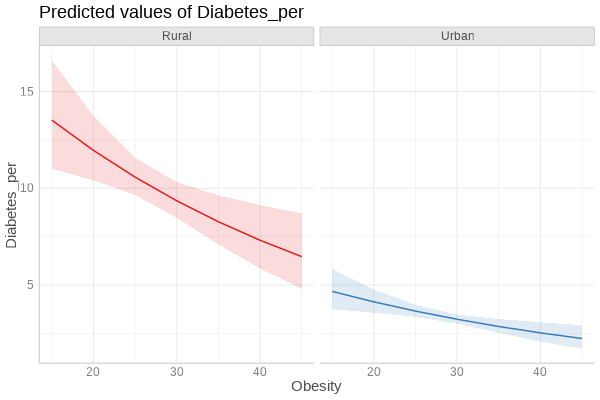

In [ ]:
%%R -h 400 -w 600 -u px
plot(predict_response(fit.qpois, terms = c("Obesity", "Urban_Rural"), condition = "log_POP_Total"), facets=TRUE)

`effect_plot()` function of {jtools} package plot simple effects in poisson regression models:

Using data train from global environment. This could cause incorrect
results if train has been altered since the model was fit. You can manually
provide the data to the "data =" argument.


Using data train from global environment. This could cause incorrect
results if train has been altered since the model was fit. You can manually
provide the data to the "data =" argument.


Using data train from global environment. This could cause incorrect
results if train has been altered since the model was fit. You can manually
provide the data to the "data =" argument.


Using data train from global environment. This could cause incorrect
results if train has been altered since the model was fit. You can manually
provide the data to the "data =" argument.


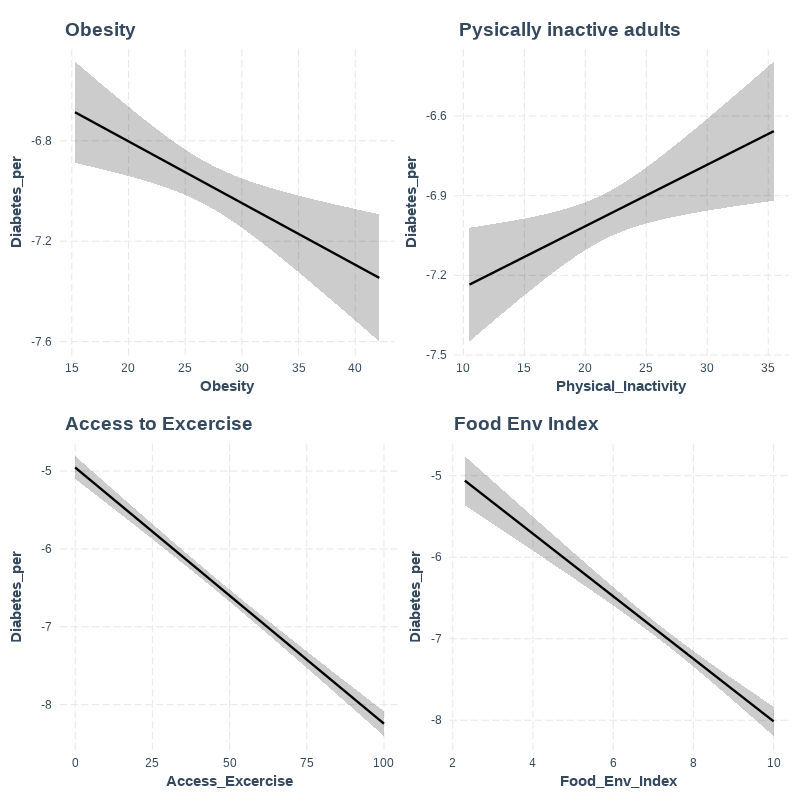

In [ ]:
%%R -h 800 -w 800 -u px

p1<-jtools::effect_plot(fit.qpois,
                    main.title = "Obesity",
                    pred = Obesity,
                    interval = T,
                    outcome.scale = "link",
                    partial.residuals = F)
p2<-jtools::effect_plot(fit.qpois,
                    main.title = "Pysically inactive adults ",
                    pred = Physical_Inactivity,
                    interval = TRUE,
                    outcome.scale = "link",
                    partial.residuals = F)
p3<-jtools::effect_plot(fit.qpois,
                    main.title = "Access to Excercise",
                    pred = Access_Excercise ,
                    interval = TRUE,
                    outcome.scale = "link",
                    partial.residuals = F)
p4<-jtools::effect_plot(fit.qpois,
                    main.title = "Food Env Index",
                    pred = Food_Env_Index,
                    interval = TRUE,
                    outcome.scale = "link",
                    partial.residuals = F)
library(patchwork)
(p1+p2)/(p3 +p4)

### Fit a Negative Binomial Regression Model

We will fit the negative binomial regression model using `glm.nb()` function of {MASS} package.

In [ ]:
%%R
fit.nb <- glm.nb(
       Diabetes_per  ~
                Obesity +
                Physical_Inactivity +
                Access_Excercise +
                Food_Env_Index +
                SVI +
                Urban_Rural+
                offset(log_POP_Total),
                data = train)

#### Model Summary

In [ ]:
%%R
summary(fit.nb)



Call:
glm.nb(formula = Diabetes_per ~ Obesity + Physical_Inactivity + 
    Access_Excercise + Food_Env_Index + SVI + Urban_Rural + offset(log_POP_Total), 
    data = train, init.theta = 2.033905175, link = log)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.0580592  0.1928039 -10.674  < 2e-16 ***
Obesity             -0.0623632  0.0060850 -10.249  < 2e-16 ***
Physical_Inactivity  0.0270431  0.0069035   3.917 8.95e-05 ***
Access_Excercise    -0.0212910  0.0009096 -23.406  < 2e-16 ***
Food_Env_Index      -0.3049388  0.0211116 -14.444  < 2e-16 ***
SVI                 -1.2840924  0.0758735 -16.924  < 2e-16 ***
Urban_RuralUrban    -1.0691095  0.0388256 -27.536  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(2.0339) family taken to be 1)

    Null deviance: 5611.1  on 2172  degrees of freedom
Residual deviance: 2418.8  on 2166  degrees of freedom
AIC: 14582

Numb

#### Model Performance

In [ ]:
%%R
performance::performance(fit.nb)

# Indices of model performance

AIC       |      AICc |       BIC | Nagelkerke's R2 |   RMSE | Sigma | Score_log | Score_spherical
--------------------------------------------------------------------------------------------------
14582.488 | 14582.554 | 14627.959 |           0.833 | 25.062 | 1.000 |    -3.432 |           0.019


#### Incidence Rate Ratio (IRR)

In [ ]:
%%R
tidy(fit.nb, exponentiate = TRUE,
                       conf.int = TRUE)

# A tibble: 7 × 7
  term                estimate std.error statistic   p.value conf.low conf.high
  <chr>                  <dbl>     <dbl>     <dbl>     <dbl>    <dbl>     <dbl>
1 (Intercept)            0.128  0.193       -10.7  1.34e- 26   0.0877     0.186
2 Obesity                0.940  0.00608     -10.2  1.20e- 24   0.928      0.952
3 Physical_Inactivity    1.03   0.00690       3.92 8.95e-  5   1.01       1.04 
4 Access_Excercise       0.979  0.000910    -23.4  3.68e-121   0.977      0.981
5 Food_Env_Index         0.737  0.0211      -14.4  2.73e- 47   0.707      0.768
6 SVI                    0.277  0.0759      -16.9  2.99e- 64   0.238      0.322
7 Urban_RuralUrban       0.343  0.0388      -27.5  6.48e-167   0.318      0.370


### Model Comparison

In [ ]:
%%R
# extract coefficients from poisson model using 'coef()'
coef1 = coef(fit.pois)
# extract coefficients from quasi-model model
coef2 = coef(fit.qpois)
# extract coefficients from negtive binomial model
coef3 = coef(fit.nb)

# extract standard errors f
se.coef1 = summary(fit.pois)$coefficients[, 2]
se.coef2 = summary(fit.qpois)$coefficients[, 2]
se.coef3 = summary(fit.nb)$coefficients[, 2]

# use 'cbind()' to combine values into one dataframe
model.all <- cbind(coef1, se.coef1, coef2, se.coef2, coef3, se.coef3 )
model.all

                          coef1     se.coef1       coef2    se.coef2
(Intercept)         -2.11379767 0.0882815165 -2.11379767 0.276970150
Obesity             -0.02458873 0.0025488700 -0.02458873 0.007996701
Physical_Inactivity  0.02315297 0.0028876050  0.02315297 0.009059432
Access_Excercise    -0.03291368 0.0004250686 -0.03291368 0.001333590
Food_Env_Index      -0.38352972 0.0093947071 -0.38352972 0.029474499
SVI                 -1.69211275 0.0349250360 -1.69211275 0.109572115
Urban_RuralUrban    -1.06352403 0.0199055182 -1.06352403 0.062450607
                          coef3    se.coef3
(Intercept)         -2.05805920 0.192803901
Obesity             -0.06236315 0.006084979
Physical_Inactivity  0.02704309 0.006903477
Access_Excercise    -0.02129096 0.000909622
Food_Env_Index      -0.30493883 0.021111551
SVI                 -1.28409241 0.075873523
Urban_RuralUrban    -1.06910948 0.038825613


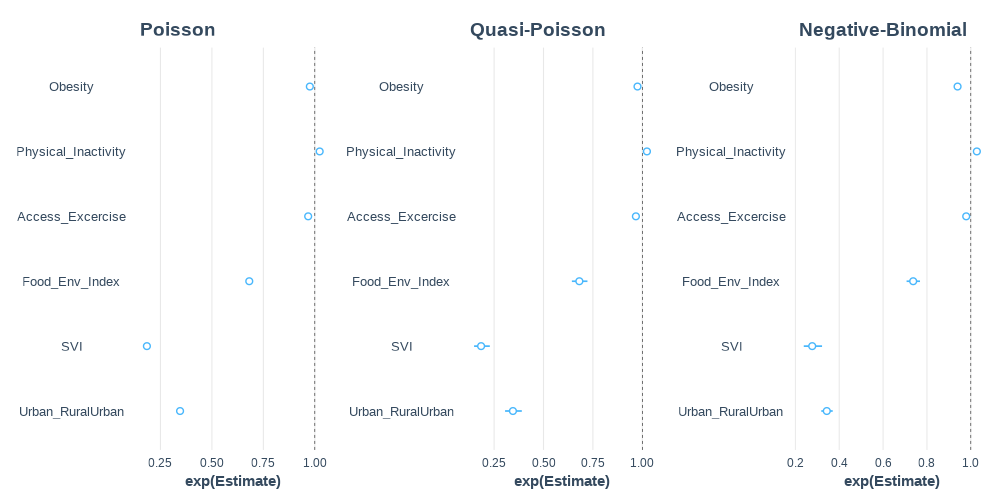

In [ ]:
%%R -h 500 -w 1000 -u px
p1.irr<-jtools::plot_coefs(fit.pois, scale = TRUE, exp = TRUE) +
    ggtitle("Poisson")
p2.irr<-jtools::plot_coefs(fit.qpois, scale = TRUE, exp = TRUE) +
    ggtitle("Quasi-Poisson")
p3.irr<-jtools::plot_coefs(fit.nb, scale = TRUE, exp = TRUE) +
    ggtitle("Negative-Binomial")
p1.irr+p2.irr+p3.irr

The output figure illustrates that the coefficients in both the Poisson and Quasi-Poisson models are identical. However, the standard errors of the coefficients are different. Specifically, fitting a Quasi-Poisson result in larger standard errors for Food ENV Index, and Urban/Rural compared to a Poisson and Negative Binomial models. The larger standard errors in this models are due to the model being more flexible, allowing for over-dispersion to be accounted for. These models, therefore, have a larger number of parameters to estimate, which leads to a larger variance in the estimated parameters. As a result, the confidence intervals for the coefficients in the Quasi-Poisson and Negative-Binomial models are wider, indicating a lower level of precision in the parameter estimates.

#### AIC (Akaike Information Criterion) / BIC (Bayesian Information Criterion):

-   Both the AIC and BIC are used to compare models based on how well they fit the data, while penalizing for the number of parameters to avoid overfitting.

-   The model with the lower AIC/BIC value is preferred.

-   To compare Quasi and NB models, fit both models and compare their AIC/BIC values

In [ ]:
%%R
AIC(fit.pois, fit.nb)
BIC(fit.pois,  fit.nb)

         df      BIC
fit.pois  7 21796.20
fit.nb    8 14627.96


#### Likelihood Ratio Test (LRT):

The Likelihood Ratio Test (LRT) in R is used to compare two nested models, where one model is a simpler version (restricted) of another, more complex model. In the context of count data models, this can be used to compare a simpler Poisson regression model to a more complex model like a Negative Binomial regression model, provided that they are nested.

The LRT tests the null hypothesis that the simpler model fits the data just as well as the more complex one. The test statistic follows a chi-squared distribution, with degrees of freedom equal to the difference in the number of parameters between the two models.

A likelihood ratio test can be used to compare models that are nested (i.e., one model is a special case of another). However, Poisson and Quasi-piosson are not nested models, so the LRT is not applicable directly for comparing them. You can perform a similar test when comparing simpler versions of the models, like Poisson vs. NB.

In [ ]:
%%R
# 1. Extract log-likelihoods
logLik.pois <- logLik(fit.pois)
logLik.nb <- logLik(fit.nb)
# 2. Compute the LRT statistic
lrt_stat <- 2 * (logLik.nb - logLik.pois)
# 3. Degrees of freedom difference (df)
df_diff <- attr(logLik.nb, "df") - attr(logLik.nb, "df")
# 4. Compute p-value (chi-squared distribution)
p_value <- pchisq(lrt_stat, df = df_diff, lower.tail = FALSE)
# Output LRT statistic and p-value
cat("LRT Statistic:", lrt_stat, "\n")
cat("Degrees of Freedom Difference:", df_diff, "\n")
cat("p-value:", p_value, "\n")

LRT Statistic: 7175.922 
Degrees of Freedom Difference: 0 
p-value: 0 


The p-value is very small (e.g., less than 0.05), we reject the null hypothesis that the simpler Poisson model is sufficient. This suggests that the more complex negative binomial model is a better fit.

### Prediction Performance

The `predict()` function will be used to predict the number of diabetes patients the test counties. This will help to validate the accuracy of the these regression models.

In [ ]:
%%R
# Prediction
test$Pred.pois<-predict(fit.pois, test, type = "response")
test$Pred.qpois<-predict(fit.qpois, test, type = "response")
test$Pred.nb<-predict(fit.nb, test, type = "response")
# RMSE
rmse.pois<-Metrics::rmse(test$Diabetes_per, test$Pred.pois)
rmse.qpois<-Metrics::rmse(test$Diabetes_per, test$Pred.qpois)
rmse.nb<-Metrics::rmse(test$Diabetes_per, test$Pred.nb)

cat("RMSE Poisson:", rmse.pois, "\n")
cat("RMSE Quasi-Poisson:", rmse.qpois, "\n")
cat("RMSE Negative Binomial:", rmse.nb)




RMSE Poisson: 13.34734 
RMSE Quasi-Poisson: 13.34734 
RMSE Negative Binomial: 23.25059